<a href="https://colab.research.google.com/github/maulanawirawan/FPN-with-EFFICIENTNET-B7-backbone-for-Segmentation-Task/blob/main/FPN_backbone_efficientnet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
# Mengaitkan dan mengakses Google Drive ke dalam lingkungan kerja Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
from torchvision.transforms import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from segmentation_models_pytorch.losses import DiceLoss
import segmentation_models_pytorch as smp

In [ ]:
from dataclasses import dataclass

@dataclass
class Args:
    model: str = 'fpn'
    epochs: int = 100
    batch_size: int = 2
    learning_rate: float = 1e-5
    path_to_train_images: str = '/content/drive/MyDrive/segmentasi/segmentasi/train/mandible/images'
    path_to_train_masks: str = '/content/drive/MyDrive/segmentasi/segmentasi/train/mandible/masks'
    path_to_val_images: str = '/content/drive/MyDrive/segmentasi/segmentasi/val/mandible/images'
    path_to_val_masks: str = '/content/drive/MyDrive/segmentasi/segmentasi/val/mandible/masks'
    path_to_test_images: str = '/content/drive/MyDrive/segmentasi/segmentasi/test/mandible/images'
    path_to_test_masks: str = '/content/drive/MyDrive/segmentasi/segmentasi/test/mandible/masks'
    scale: float = 0.3

args = Args()

def pad(img, pad_size=32):
    height, width = img.shape[:2]
    if height % pad_size == 0 and width % pad_size == 0:
        return img
    else:
        new_height = ((height // pad_size) + 1) * pad_size
        new_width = ((width // pad_size) + 1) * pad_size
        padded_img = np.zeros((new_height, new_width), dtype=np.float32)
        padded_img[:height, :width] = img
        return padded_img

In [ ]:
class MandibleDataset(Dataset):
    def __init__(self, path_to_images,path_to_masks, transform=None):
        self.path_to_images = path_to_images
        self.path_to_masks= path_to_masks
        self.transform = transform
        self.images = []
        self.masks = []
        for filename in os.listdir(self.path_to_images):
            img = cv2.imread(os.path.join(self.path_to_images, filename), 0)
            img=cv2.resize(img , (928,416))
            img=pad(img)
            img-=img.min()
            img = img.astype(np.float32) / img.max()
            self.images.append(img)
        i=-1
        for filename in os.listdir(self.path_to_masks):
            i+=1
            mask = cv2.imread(os.path.join(self.path_to_masks, filename), 0)
            mask=cv2.resize(mask , (928,416))
            mask=pad(mask)
            mask-=mask.min()
            mask = mask.astype(np.float32) / mask.max()
            mask=np.where(mask==np.unique(mask)[0],0,1)
            self.masks.append(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform is not None:
            image = self.transform(image).to(device).contiguous()
            mask = self.transform(mask).to(device).contiguous()
        return image, mask

In [ ]:
def Dice(output,target,weight=None, eps=1e-5):
    target = target.float()
    if weight is None:
        num = 2 * (output * target).sum()
        den = output.sum() + target.sum() + eps
    return 1.0 - num/den

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    total_dice = 0
    total_f1 = 0
    total_acc = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        target=target.squeeze(1).long()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        total_dice += Dice(output[:,0,:,:], target).item()
        total_f1 += f1_score(output[:,0,:,:], target).item()
        total_acc += accuracy(output[:,0,:,:], target).item()
    train_loss /= len(train_loader)
    total_dice /= len(train_loader)
    total_f1 /= len(train_loader)
    total_acc /= len(train_loader)
    return train_loss, total_dice, total_f1, total_acc

In [ ]:
def f1_score(output, target, eps=1e-5):
    output = torch.sigmoid(output)  # apply sigmoid on the output
    output = (output > 0.5).float()  # apply a threshold to the output
    intersection = (output * target).sum()
    union = output.sum() + target.sum() + eps
    f1 = 2 * intersection / union
    return f1

In [ ]:
def accuracy(output, target):
    output = torch.sigmoid(output)  # apply sigmoid on the output
    output = (output > 0.5).float()  # apply a threshold to the output
    correct = (output == target).float().sum()
    total = target.numel()
    acc = correct / total
    return acc

def IoU(output, target, eps=1e-5):
    output = torch.sigmoid(output)  # apply sigmoid on the output
    output = (output > 0.5).float()  # apply a threshold to the output
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection + eps
    return intersection / union

In [ ]:
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    total_dice = 0
    total_f1 = 0
    total_acc = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target=target.squeeze(1).long()
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            total_dice += Dice(output[:,0,:,:], target).item()
            total_f1 += f1_score(output[:,0,:,:], target).item()
            total_acc += accuracy(output[:,0,:,:], target).item()
    val_loss /= len(val_loader)
    total_dice /= len(val_loader)
    total_f1 /= len(val_loader)
    total_acc /= len(val_loader)
    return val_loss, total_dice, total_f1, total_acc

In [ ]:
def plot_f1(train_f1, val_f1):
    plt.plot(train_f1, label='Train F1 score')
    plt.plot(val_f1, label='Validation F1 score')
    plt.title('Train and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 score')
    plt.legend()
    plt.show()

def plot_accuracy(train_acc, val_acc):
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_dice(train_dice, val_dice):
    plt.plot(train_dice, label='Train dice score')
    plt.plot(val_dice, label='Validation dice score')
    plt.title('Train and Validation Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice score')
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms import ToPILImage

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(ToPILImage()(display_list[i].astype(np.float32)), cmap='gray')
        plt.axis('off')
    plt.show()

# Create dataset
train_dataset = MandibleDataset(args.path_to_train_images, args.path_to_train_masks)

# Display first 5 images and masks
for i in range(5):
    image, mask = train_dataset[i]
    image = torch.from_numpy(image).cpu().numpy()
    mask = torch.from_numpy(mask).cpu().numpy()
    display([image, mask])

In [ ]:
def train_model(model, epochs, batch_size, learning_rate, device):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    criterion = DiceLoss('multiclass')
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    train_dataset = MandibleDataset(args.path_to_train_images, args.path_to_train_masks, transform=transform)
    val_dataset = MandibleDataset(args.path_to_val_images, args.path_to_val_masks, transform=transform)
    n_val = int(len(train_dataset) * 0.2)
    n_train = len(train_dataset) - n_val
    train_set, val_set = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(13))
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)  # Define val_loader here
    train_loss_list = []
    val_loss_list = []
    train_dice_list = []
    val_dice_list = []
    train_f1_list = []  # Added
    val_f1_list = []  # Added
    train_acc_list = []  # Added
    val_acc_list = []  # Added
    min_val_loss = 1000
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        train_loss, train_dice, train_f1, train_acc = train(model, device, train_loader, optimizer, criterion)  # Updated
        print(f'Train loss: {train_loss:.6f}, Train dice score: {train_dice:.6f}, Train F1 score: {train_f1:.6f}, Train accuracy: {train_acc:.6f}')  # Updated
        val_loss, val_dice, val_f1, val_acc = validate(model, device, val_loader, criterion)  # Updated
        print(f'Validation loss: {val_loss:.6f}, Validation dice score: {val_dice:.6f}, Validation F1 score: {val_f1:.6f}, Validation accuracy: {val_acc:.6f}')  # Updated
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_dice_list.append(train_dice)
        val_dice_list.append(val_dice)
        train_f1_list.append(train_f1)  # Added
        val_f1_list.append(val_f1)  # Added
        train_acc_list.append(train_acc)  # Added
        val_acc_list.append(val_acc)  # Added
        torch.save(model.state_dict(), 'checkpoints/{}_model_epoch{}.pth'.format(args.model, epoch + 1))
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), 'checkpoints/{}_model_best.pth'.format(args.model))
    plot_loss(train_loss_list, val_loss_list)
    plot_dice(train_dice_list, val_dice_list)
    # You can add functions to plot the F1 score and accuracy over epochs here
    plot_f1(train_f1_list, val_f1_list)  # Added
    plot_accuracy(train_acc_list, val_acc_list)  # Added

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 364MB/s]
<ipython-input-5-62a50dd7f791>:22: RuntimeWarning: invalid value encountered in divide
  mask = mask.astype(np.float32) / mask.max()


Epoch 1/100


100%|██████████| 30/30 [00:18<00:00,  1.62it/s]


Train loss: 0.401348, Train dice score: 0.691857, Train F1 score: 0.638539, Train accuracy: 0.479262
Validation loss: 0.390305, Validation dice score: 0.729976, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 2/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.366922, Train dice score: 0.783728, Train F1 score: 0.637088, Train accuracy: 0.479235
Validation loss: 0.371707, Validation dice score: 0.779973, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 3/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.358743, Train dice score: 0.795189, Train F1 score: 0.637505, Train accuracy: 0.479200
Validation loss: 0.360172, Validation dice score: 0.815835, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 4/100


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


Train loss: 0.340577, Train dice score: 0.813238, Train F1 score: 0.634611, Train accuracy: 0.478789
Validation loss: 0.352206, Validation dice score: 0.852719, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 5/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.338848, Train dice score: 0.815220, Train F1 score: 0.634161, Train accuracy: 0.478357
Validation loss: 0.345205, Validation dice score: 0.878932, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 6/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.335754, Train dice score: 0.830885, Train F1 score: 0.632728, Train accuracy: 0.476723
Validation loss: 0.336950, Validation dice score: 0.880379, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 7/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.344612, Train dice score: 0.823522, Train F1 score: 0.636235, Train accuracy: 0.477526
Validation loss: 0.333495, Validation dice score: 0.909522, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 8/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.330738, Train dice score: 0.844038, Train F1 score: 0.630896, Train accuracy: 0.474505
Validation loss: 0.328330, Validation dice score: 0.904576, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 9/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.316757, Train dice score: 0.843820, Train F1 score: 0.623956, Train accuracy: 0.471064
Validation loss: 0.328172, Validation dice score: 0.921437, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 10/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.338684, Train dice score: 0.840024, Train F1 score: 0.631243, Train accuracy: 0.472214
Validation loss: 0.327998, Validation dice score: 0.931385, Validation F1 score: 0.561595, Validation accuracy: 0.390580
Epoch 11/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.324080, Train dice score: 0.854610, Train F1 score: 0.620469, Train accuracy: 0.464814
Validation loss: 0.325845, Validation dice score: 0.925574, Validation F1 score: 0.561599, Validation accuracy: 0.390583
Epoch 12/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.322705, Train dice score: 0.853828, Train F1 score: 0.616175, Train accuracy: 0.459476
Validation loss: 0.324290, Validation dice score: 0.923621, Validation F1 score: 0.561502, Validation accuracy: 0.390489
Epoch 13/100


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


Train loss: 0.332864, Train dice score: 0.851480, Train F1 score: 0.619673, Train accuracy: 0.460156
Validation loss: 0.328721, Validation dice score: 0.938835, Validation F1 score: 0.561345, Validation accuracy: 0.390336
Epoch 14/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.331008, Train dice score: 0.863051, Train F1 score: 0.617873, Train accuracy: 0.459590
Validation loss: 0.325992, Validation dice score: 0.929064, Validation F1 score: 0.561259, Validation accuracy: 0.390251
Epoch 15/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.329419, Train dice score: 0.860942, Train F1 score: 0.609512, Train accuracy: 0.450883
Validation loss: 0.325034, Validation dice score: 0.932739, Validation F1 score: 0.560625, Validation accuracy: 0.389637
Epoch 16/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.328035, Train dice score: 0.867300, Train F1 score: 0.607839, Train accuracy: 0.448332
Validation loss: 0.323229, Validation dice score: 0.923441, Validation F1 score: 0.559773, Validation accuracy: 0.388814
Epoch 17/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.327227, Train dice score: 0.863449, Train F1 score: 0.599545, Train accuracy: 0.440969
Validation loss: 0.324018, Validation dice score: 0.929533, Validation F1 score: 0.558692, Validation accuracy: 0.387772
Epoch 18/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.325744, Train dice score: 0.872626, Train F1 score: 0.586430, Train accuracy: 0.428853
Validation loss: 0.324108, Validation dice score: 0.933230, Validation F1 score: 0.556146, Validation accuracy: 0.385329
Epoch 19/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.311869, Train dice score: 0.876526, Train F1 score: 0.568064, Train accuracy: 0.413846
Validation loss: 0.324702, Validation dice score: 0.930067, Validation F1 score: 0.554273, Validation accuracy: 0.383542
Epoch 20/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.322951, Train dice score: 0.874983, Train F1 score: 0.585435, Train accuracy: 0.427284
Validation loss: 0.326258, Validation dice score: 0.947050, Validation F1 score: 0.547273, Validation accuracy: 0.376957
Epoch 21/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.321119, Train dice score: 0.882533, Train F1 score: 0.565133, Train accuracy: 0.410274
Validation loss: 0.322927, Validation dice score: 0.941457, Validation F1 score: 0.542153, Validation accuracy: 0.372170
Epoch 22/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.319344, Train dice score: 0.886636, Train F1 score: 0.556814, Train accuracy: 0.401873
Validation loss: 0.321804, Validation dice score: 0.933104, Validation F1 score: 0.542229, Validation accuracy: 0.372223
Epoch 23/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.318766, Train dice score: 0.888795, Train F1 score: 0.558700, Train accuracy: 0.403040
Validation loss: 0.320843, Validation dice score: 0.929439, Validation F1 score: 0.531922, Validation accuracy: 0.362657
Epoch 24/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.297041, Train dice score: 0.891530, Train F1 score: 0.555360, Train accuracy: 0.406448
Validation loss: 0.319362, Validation dice score: 0.936934, Validation F1 score: 0.518293, Validation accuracy: 0.350300
Epoch 25/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.306963, Train dice score: 0.893775, Train F1 score: 0.546549, Train accuracy: 0.396249
Validation loss: 0.318411, Validation dice score: 0.929633, Validation F1 score: 0.507486, Validation accuracy: 0.340530
Epoch 26/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.315420, Train dice score: 0.898000, Train F1 score: 0.541245, Train accuracy: 0.390171
Validation loss: 0.318384, Validation dice score: 0.929653, Validation F1 score: 0.483199, Validation accuracy: 0.319133
Epoch 27/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.314916, Train dice score: 0.899457, Train F1 score: 0.525551, Train accuracy: 0.373067
Validation loss: 0.319325, Validation dice score: 0.938274, Validation F1 score: 0.479714, Validation accuracy: 0.316171
Epoch 28/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.315497, Train dice score: 0.899039, Train F1 score: 0.536509, Train accuracy: 0.383110
Validation loss: 0.320547, Validation dice score: 0.942656, Validation F1 score: 0.472399, Validation accuracy: 0.309995
Epoch 29/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.312566, Train dice score: 0.905299, Train F1 score: 0.516699, Train accuracy: 0.367523
Validation loss: 0.320957, Validation dice score: 0.942028, Validation F1 score: 0.463019, Validation accuracy: 0.302317
Epoch 30/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.300446, Train dice score: 0.910480, Train F1 score: 0.505422, Train accuracy: 0.361150
Validation loss: 0.323056, Validation dice score: 0.947841, Validation F1 score: 0.448343, Validation accuracy: 0.290517
Epoch 31/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.310547, Train dice score: 0.914051, Train F1 score: 0.516838, Train accuracy: 0.366747
Validation loss: 0.323100, Validation dice score: 0.944231, Validation F1 score: 0.444056, Validation accuracy: 0.287040
Epoch 32/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.307988, Train dice score: 0.920080, Train F1 score: 0.513642, Train accuracy: 0.363697
Validation loss: 0.325329, Validation dice score: 0.948537, Validation F1 score: 0.447726, Validation accuracy: 0.290032
Epoch 33/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.307623, Train dice score: 0.922843, Train F1 score: 0.525586, Train accuracy: 0.375001
Validation loss: 0.323852, Validation dice score: 0.948293, Validation F1 score: 0.434548, Validation accuracy: 0.279321
Epoch 34/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.298610, Train dice score: 0.924005, Train F1 score: 0.492686, Train accuracy: 0.350214
Validation loss: 0.323564, Validation dice score: 0.944694, Validation F1 score: 0.428171, Validation accuracy: 0.274244
Epoch 35/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.304487, Train dice score: 0.932652, Train F1 score: 0.502898, Train accuracy: 0.355115
Validation loss: 0.324122, Validation dice score: 0.946986, Validation F1 score: 0.427902, Validation accuracy: 0.274210
Epoch 36/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.304186, Train dice score: 0.932825, Train F1 score: 0.502326, Train accuracy: 0.355235
Validation loss: 0.325529, Validation dice score: 0.949113, Validation F1 score: 0.418963, Validation accuracy: 0.266913
Epoch 37/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.294965, Train dice score: 0.934033, Train F1 score: 0.483527, Train accuracy: 0.343603
Validation loss: 0.325656, Validation dice score: 0.947241, Validation F1 score: 0.417018, Validation accuracy: 0.265477
Epoch 38/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.302354, Train dice score: 0.942455, Train F1 score: 0.491048, Train accuracy: 0.346690
Validation loss: 0.323528, Validation dice score: 0.946344, Validation F1 score: 0.418220, Validation accuracy: 0.266302
Epoch 39/100


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


Train loss: 0.294579, Train dice score: 0.937825, Train F1 score: 0.495795, Train accuracy: 0.352778
Validation loss: 0.322331, Validation dice score: 0.941839, Validation F1 score: 0.409258, Validation accuracy: 0.259229
Epoch 40/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.300214, Train dice score: 0.947197, Train F1 score: 0.489566, Train accuracy: 0.346891
Validation loss: 0.321475, Validation dice score: 0.945515, Validation F1 score: 0.408688, Validation accuracy: 0.258924
Epoch 41/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.291415, Train dice score: 0.943453, Train F1 score: 0.488404, Train accuracy: 0.347781
Validation loss: 0.324194, Validation dice score: 0.947670, Validation F1 score: 0.408709, Validation accuracy: 0.258863
Epoch 42/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.299699, Train dice score: 0.951311, Train F1 score: 0.495855, Train accuracy: 0.349442
Validation loss: 0.322556, Validation dice score: 0.946683, Validation F1 score: 0.404937, Validation accuracy: 0.256088
Epoch 43/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.298664, Train dice score: 0.951257, Train F1 score: 0.478523, Train accuracy: 0.335307
Validation loss: 0.322843, Validation dice score: 0.943611, Validation F1 score: 0.398344, Validation accuracy: 0.251037
Epoch 44/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.282775, Train dice score: 0.942077, Train F1 score: 0.472158, Train accuracy: 0.339384
Validation loss: 0.320732, Validation dice score: 0.943791, Validation F1 score: 0.391209, Validation accuracy: 0.245413
Epoch 45/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289906, Train dice score: 0.949920, Train F1 score: 0.471533, Train accuracy: 0.334723
Validation loss: 0.324779, Validation dice score: 0.952102, Validation F1 score: 0.394935, Validation accuracy: 0.248428
Epoch 46/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.296492, Train dice score: 0.955367, Train F1 score: 0.470932, Train accuracy: 0.328098
Validation loss: 0.322307, Validation dice score: 0.948032, Validation F1 score: 0.382575, Validation accuracy: 0.239192
Epoch 47/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.297296, Train dice score: 0.958168, Train F1 score: 0.463901, Train accuracy: 0.323533
Validation loss: 0.320756, Validation dice score: 0.951036, Validation F1 score: 0.382068, Validation accuracy: 0.238666
Epoch 48/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.288642, Train dice score: 0.952836, Train F1 score: 0.461694, Train accuracy: 0.326052
Validation loss: 0.322010, Validation dice score: 0.949997, Validation F1 score: 0.373447, Validation accuracy: 0.232231
Epoch 49/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.295238, Train dice score: 0.960940, Train F1 score: 0.463906, Train accuracy: 0.324043
Validation loss: 0.320403, Validation dice score: 0.945747, Validation F1 score: 0.370251, Validation accuracy: 0.229887
Epoch 50/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.296519, Train dice score: 0.957338, Train F1 score: 0.470959, Train accuracy: 0.328425
Validation loss: 0.321438, Validation dice score: 0.945246, Validation F1 score: 0.368933, Validation accuracy: 0.228970
Epoch 51/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.296112, Train dice score: 0.961006, Train F1 score: 0.445072, Train accuracy: 0.309442
Validation loss: 0.320840, Validation dice score: 0.942686, Validation F1 score: 0.364628, Validation accuracy: 0.225763
Epoch 52/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.295625, Train dice score: 0.961168, Train F1 score: 0.453477, Train accuracy: 0.317229
Validation loss: 0.320337, Validation dice score: 0.947617, Validation F1 score: 0.359712, Validation accuracy: 0.222188
Epoch 53/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.294217, Train dice score: 0.963350, Train F1 score: 0.448383, Train accuracy: 0.312734
Validation loss: 0.321777, Validation dice score: 0.948753, Validation F1 score: 0.354375, Validation accuracy: 0.218465
Epoch 54/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.286510, Train dice score: 0.961749, Train F1 score: 0.450616, Train accuracy: 0.315715
Validation loss: 0.319633, Validation dice score: 0.944119, Validation F1 score: 0.342513, Validation accuracy: 0.209739
Epoch 55/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.295181, Train dice score: 0.963513, Train F1 score: 0.441834, Train accuracy: 0.309451
Validation loss: 0.321922, Validation dice score: 0.949071, Validation F1 score: 0.341257, Validation accuracy: 0.209006
Epoch 56/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.293760, Train dice score: 0.967012, Train F1 score: 0.442085, Train accuracy: 0.306139
Validation loss: 0.320199, Validation dice score: 0.947291, Validation F1 score: 0.335420, Validation accuracy: 0.204904
Epoch 57/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.286394, Train dice score: 0.965665, Train F1 score: 0.422426, Train accuracy: 0.296297
Validation loss: 0.319727, Validation dice score: 0.940297, Validation F1 score: 0.348322, Validation accuracy: 0.213859
Epoch 58/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.293455, Train dice score: 0.966097, Train F1 score: 0.456231, Train accuracy: 0.319040
Validation loss: 0.319016, Validation dice score: 0.941123, Validation F1 score: 0.336767, Validation accuracy: 0.206024
Epoch 59/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.278004, Train dice score: 0.957825, Train F1 score: 0.423086, Train accuracy: 0.301728
Validation loss: 0.324291, Validation dice score: 0.946521, Validation F1 score: 0.331741, Validation accuracy: 0.202600
Epoch 60/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.293828, Train dice score: 0.967829, Train F1 score: 0.431849, Train accuracy: 0.298073
Validation loss: 0.324687, Validation dice score: 0.948732, Validation F1 score: 0.335308, Validation accuracy: 0.205153
Epoch 61/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.292649, Train dice score: 0.969375, Train F1 score: 0.431889, Train accuracy: 0.298460
Validation loss: 0.318595, Validation dice score: 0.943725, Validation F1 score: 0.321672, Validation accuracy: 0.195082
Epoch 62/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.293849, Train dice score: 0.965050, Train F1 score: 0.436696, Train accuracy: 0.301680
Validation loss: 0.321190, Validation dice score: 0.943349, Validation F1 score: 0.329872, Validation accuracy: 0.200795
Epoch 63/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.291942, Train dice score: 0.968198, Train F1 score: 0.432627, Train accuracy: 0.299803
Validation loss: 0.322522, Validation dice score: 0.948736, Validation F1 score: 0.322574, Validation accuracy: 0.196205
Epoch 64/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.283365, Train dice score: 0.968647, Train F1 score: 0.403416, Train accuracy: 0.280590
Validation loss: 0.323279, Validation dice score: 0.948712, Validation F1 score: 0.309246, Validation accuracy: 0.187018
Epoch 65/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.292994, Train dice score: 0.972318, Train F1 score: 0.419646, Train accuracy: 0.289114
Validation loss: 0.321076, Validation dice score: 0.945538, Validation F1 score: 0.317470, Validation accuracy: 0.192475
Epoch 66/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.284023, Train dice score: 0.967117, Train F1 score: 0.408047, Train accuracy: 0.282324
Validation loss: 0.320376, Validation dice score: 0.943856, Validation F1 score: 0.317031, Validation accuracy: 0.192277
Epoch 67/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.292223, Train dice score: 0.972831, Train F1 score: 0.422835, Train accuracy: 0.288968
Validation loss: 0.316959, Validation dice score: 0.941016, Validation F1 score: 0.313481, Validation accuracy: 0.189567
Epoch 68/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.284074, Train dice score: 0.969263, Train F1 score: 0.398956, Train accuracy: 0.278866
Validation loss: 0.319527, Validation dice score: 0.946152, Validation F1 score: 0.317166, Validation accuracy: 0.192439
Epoch 69/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.283865, Train dice score: 0.968478, Train F1 score: 0.392381, Train accuracy: 0.272235
Validation loss: 0.324197, Validation dice score: 0.946610, Validation F1 score: 0.315718, Validation accuracy: 0.191779
Epoch 70/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.283580, Train dice score: 0.971875, Train F1 score: 0.416715, Train accuracy: 0.292411
Validation loss: 0.322286, Validation dice score: 0.951039, Validation F1 score: 0.295212, Validation accuracy: 0.177895
Epoch 71/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.291444, Train dice score: 0.973894, Train F1 score: 0.410141, Train accuracy: 0.280656
Validation loss: 0.320506, Validation dice score: 0.952521, Validation F1 score: 0.296488, Validation accuracy: 0.178797
Epoch 72/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.283965, Train dice score: 0.972679, Train F1 score: 0.402800, Train accuracy: 0.280252
Validation loss: 0.320308, Validation dice score: 0.948773, Validation F1 score: 0.294518, Validation accuracy: 0.177007
Epoch 73/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.291595, Train dice score: 0.975214, Train F1 score: 0.389499, Train accuracy: 0.268032
Validation loss: 0.318901, Validation dice score: 0.943959, Validation F1 score: 0.292886, Validation accuracy: 0.176097
Epoch 74/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.283640, Train dice score: 0.970493, Train F1 score: 0.408351, Train accuracy: 0.286676
Validation loss: 0.318393, Validation dice score: 0.941624, Validation F1 score: 0.293703, Validation accuracy: 0.176505
Epoch 75/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.283245, Train dice score: 0.968792, Train F1 score: 0.408832, Train accuracy: 0.285346
Validation loss: 0.326451, Validation dice score: 0.950972, Validation F1 score: 0.300536, Validation accuracy: 0.182308
Epoch 76/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.290042, Train dice score: 0.976701, Train F1 score: 0.408899, Train accuracy: 0.279863
Validation loss: 0.319665, Validation dice score: 0.945987, Validation F1 score: 0.287239, Validation accuracy: 0.172345
Epoch 77/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.290216, Train dice score: 0.976330, Train F1 score: 0.411489, Train accuracy: 0.283573
Validation loss: 0.319260, Validation dice score: 0.945764, Validation F1 score: 0.290055, Validation accuracy: 0.174353
Epoch 78/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.282529, Train dice score: 0.975194, Train F1 score: 0.396589, Train accuracy: 0.275861
Validation loss: 0.321120, Validation dice score: 0.947606, Validation F1 score: 0.283290, Validation accuracy: 0.170086
Epoch 79/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.282479, Train dice score: 0.975133, Train F1 score: 0.377001, Train accuracy: 0.262876
Validation loss: 0.320871, Validation dice score: 0.942159, Validation F1 score: 0.284941, Validation accuracy: 0.170861
Epoch 80/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289388, Train dice score: 0.977060, Train F1 score: 0.385977, Train accuracy: 0.264958
Validation loss: 0.320775, Validation dice score: 0.946204, Validation F1 score: 0.281378, Validation accuracy: 0.168998
Epoch 81/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.288796, Train dice score: 0.978031, Train F1 score: 0.396481, Train accuracy: 0.269630
Validation loss: 0.319917, Validation dice score: 0.944673, Validation F1 score: 0.275950, Validation accuracy: 0.165145
Epoch 82/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.274683, Train dice score: 0.973865, Train F1 score: 0.381940, Train accuracy: 0.270304
Validation loss: 0.322055, Validation dice score: 0.940818, Validation F1 score: 0.286755, Validation accuracy: 0.172589
Epoch 83/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.291483, Train dice score: 0.978023, Train F1 score: 0.400805, Train accuracy: 0.275015
Validation loss: 0.319540, Validation dice score: 0.940356, Validation F1 score: 0.291803, Validation accuracy: 0.175665
Epoch 84/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289093, Train dice score: 0.978219, Train F1 score: 0.385062, Train accuracy: 0.261121
Validation loss: 0.318118, Validation dice score: 0.942608, Validation F1 score: 0.277041, Validation accuracy: 0.166027
Epoch 85/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289904, Train dice score: 0.978781, Train F1 score: 0.386271, Train accuracy: 0.266290
Validation loss: 0.319123, Validation dice score: 0.946521, Validation F1 score: 0.274353, Validation accuracy: 0.164594
Epoch 86/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289301, Train dice score: 0.979885, Train F1 score: 0.393244, Train accuracy: 0.269602
Validation loss: 0.316815, Validation dice score: 0.942737, Validation F1 score: 0.267765, Validation accuracy: 0.159893
Epoch 87/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.282213, Train dice score: 0.968959, Train F1 score: 0.388801, Train accuracy: 0.268963
Validation loss: 0.317193, Validation dice score: 0.942910, Validation F1 score: 0.265219, Validation accuracy: 0.158276
Epoch 88/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289564, Train dice score: 0.978895, Train F1 score: 0.394779, Train accuracy: 0.272181
Validation loss: 0.317008, Validation dice score: 0.946319, Validation F1 score: 0.258063, Validation accuracy: 0.154048
Epoch 89/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289239, Train dice score: 0.980286, Train F1 score: 0.382391, Train accuracy: 0.261013
Validation loss: 0.316716, Validation dice score: 0.944757, Validation F1 score: 0.264068, Validation accuracy: 0.157503
Epoch 90/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.288620, Train dice score: 0.980519, Train F1 score: 0.367410, Train accuracy: 0.251032
Validation loss: 0.316668, Validation dice score: 0.944838, Validation F1 score: 0.253275, Validation accuracy: 0.150724
Epoch 91/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.281343, Train dice score: 0.979624, Train F1 score: 0.381922, Train accuracy: 0.264051
Validation loss: 0.316335, Validation dice score: 0.945874, Validation F1 score: 0.254354, Validation accuracy: 0.151639
Epoch 92/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289040, Train dice score: 0.981274, Train F1 score: 0.388227, Train accuracy: 0.265633
Validation loss: 0.316261, Validation dice score: 0.946251, Validation F1 score: 0.257944, Validation accuracy: 0.154016
Epoch 93/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.288262, Train dice score: 0.982616, Train F1 score: 0.373845, Train accuracy: 0.255608
Validation loss: 0.315457, Validation dice score: 0.939292, Validation F1 score: 0.259170, Validation accuracy: 0.154339
Epoch 94/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.289387, Train dice score: 0.981078, Train F1 score: 0.378451, Train accuracy: 0.257737
Validation loss: 0.316598, Validation dice score: 0.944876, Validation F1 score: 0.252290, Validation accuracy: 0.150344
Epoch 95/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.273456, Train dice score: 0.977856, Train F1 score: 0.359598, Train accuracy: 0.253054
Validation loss: 0.323358, Validation dice score: 0.951524, Validation F1 score: 0.258010, Validation accuracy: 0.154737
Epoch 96/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.288084, Train dice score: 0.983565, Train F1 score: 0.388069, Train accuracy: 0.265211
Validation loss: 0.320134, Validation dice score: 0.946531, Validation F1 score: 0.254592, Validation accuracy: 0.152226
Epoch 97/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.288765, Train dice score: 0.983078, Train F1 score: 0.363119, Train accuracy: 0.247273
Validation loss: 0.320033, Validation dice score: 0.943735, Validation F1 score: 0.257715, Validation accuracy: 0.153867
Epoch 98/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.288485, Train dice score: 0.983928, Train F1 score: 0.376192, Train accuracy: 0.258975
Validation loss: 0.319855, Validation dice score: 0.947194, Validation F1 score: 0.258904, Validation accuracy: 0.154916
Epoch 99/100


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


Train loss: 0.288757, Train dice score: 0.983552, Train F1 score: 0.381669, Train accuracy: 0.262664
Validation loss: 0.316100, Validation dice score: 0.942920, Validation F1 score: 0.256814, Validation accuracy: 0.153048
Epoch 100/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.280554, Train dice score: 0.982388, Train F1 score: 0.358291, Train accuracy: 0.247530
Validation loss: 0.319832, Validation dice score: 0.946885, Validation F1 score: 0.249047, Validation accuracy: 0.149011


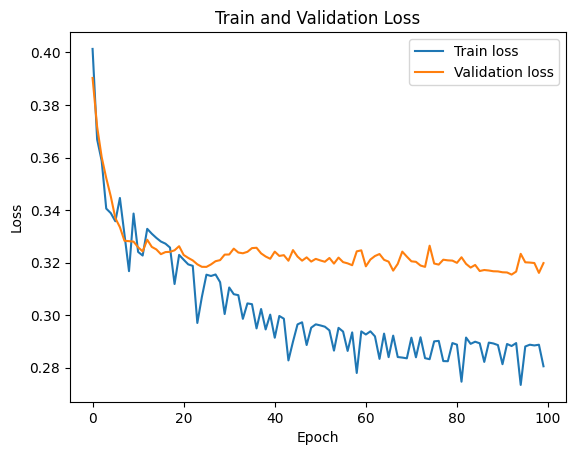

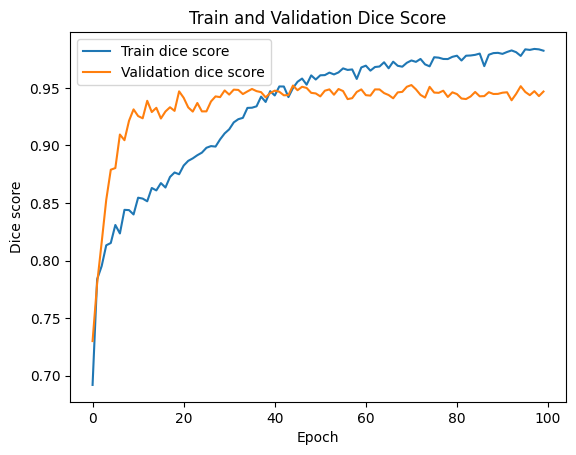

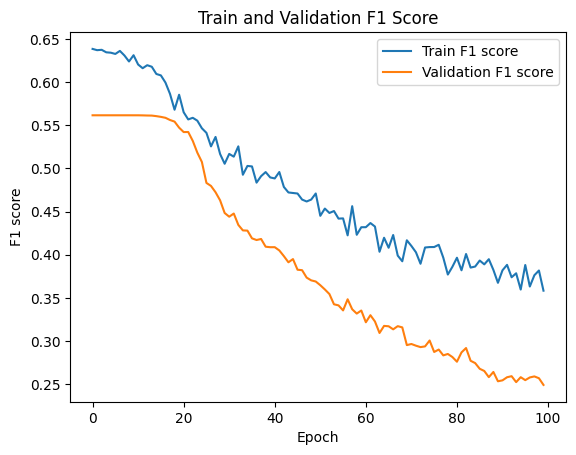

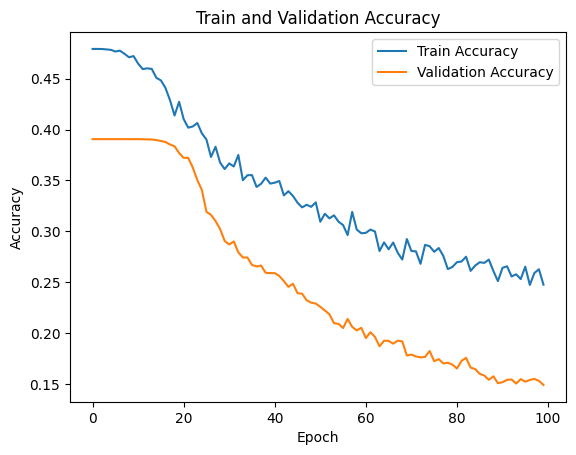

In [ ]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if args.model=='unet':
        model = smp.Unet(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    if args.model=='se_resnet':
        model = smp.Unet(
            encoder_name="se_resnet50",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    if args.model=='fpn':
        model = smp.FPN(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    if args.model=='mobilenet':
        model = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    model = model.to(memory_format=torch.channels_last)
    model.to(device=device)
    if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')
    train_model(
        model=model,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.learning_rate,
        device=device)

In [ ]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if args.model=='unet':
        model = smp.Unet(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    if args.model=='se_resnet':
        model = smp.Unet(
            encoder_name="se_resnet50",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    if args.model=='fpn':
        model = smp.FPN(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    if args.model=='mobilenet':
        model = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    model = model.to(memory_format=torch.channels_last)
    model.to(device=device)
    if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')
    train_model(
        model=model,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.learning_rate,
        device=device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 315MB/s]
<ipython-input-5-62a50dd7f791>:22: RuntimeWarning: invalid value encountered in divide
  mask = mask.astype(np.float32) / mask.max()


Epoch 1/100


100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


Train loss: 0.385433, Train dice score: 0.708965, Train F1 score: 0.632696, Train accuracy: 0.479262
Validation loss: 0.377631, Validation dice score: 0.772272, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 2/100


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


Train loss: 0.353102, Train dice score: 0.793249, Train F1 score: 0.635445, Train accuracy: 0.479262
Validation loss: 0.354349, Validation dice score: 0.802911, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 3/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.357551, Train dice score: 0.794809, Train F1 score: 0.638491, Train accuracy: 0.479261
Validation loss: 0.344493, Validation dice score: 0.857339, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 4/100


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


Train loss: 0.343447, Train dice score: 0.818423, Train F1 score: 0.635052, Train accuracy: 0.479232
Validation loss: 0.339646, Validation dice score: 0.849167, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 5/100


100%|██████████| 30/30 [00:17<00:00,  1.75it/s]


Train loss: 0.350403, Train dice score: 0.815412, Train F1 score: 0.637010, Train accuracy: 0.478364
Validation loss: 0.336021, Validation dice score: 0.864900, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 6/100


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Train loss: 0.334429, Train dice score: 0.829209, Train F1 score: 0.635266, Train accuracy: 0.479059
Validation loss: 0.330971, Validation dice score: 0.876494, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 7/100


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Train loss: 0.345355, Train dice score: 0.831705, Train F1 score: 0.635500, Train accuracy: 0.477271
Validation loss: 0.327831, Validation dice score: 0.890236, Validation F1 score: 0.561611, Validation accuracy: 0.390596
Epoch 8/100


 13%|█▎        | 4/30 [00:02<00:14,  1.77it/s]

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.FPN(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
    activation='sigmoid'
)
model.load_state_dict(torch.load('checkpoints/fpn_model_best.pth', map_location=device))
model.to(device=device)
model.eval()

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

In [ ]:
def predict_and_score(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (928, 416))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)
    mask_pred = prediction.squeeze().cpu().numpy()
    mask_pred = mask_pred / mask_pred.max() # normalize the mask here
    mask_pred = cv2.resize(mask_pred[0, :, :], (img.shape[1], img.shape[0]))  # resize the mask to the original image size

    # Load the true mask
    mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_true = cv2.resize(mask_true, (928, 416))
    mask_true = mask_true.astype(np.float32) / 255.0

    # Compute the IoU score
    iou_score = IoU(torch.from_numpy(mask_pred), torch.from_numpy(mask_true))

    return img, mask_true, mask_pred, iou_score

In [ ]:
def IoU(output, target, eps=1e-5):
    output = torch.sigmoid(output)  # apply sigmoid on the output
    output = (output > 0.5).float()  # apply a threshold to the output
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection + eps
    return intersection / union

# sampling imej lainnya pake unet

In [ ]:
# Call the predict_and_score function
image_path = '/content/drive/MyDrive/segmentasi/segmentasi/test/mandible/images/96.png'
mask_path = '/content/drive/MyDrive/segmentasi/segmentasi/test/mandible/masks/96.png'
original_img, true_mask, predicted_mask, iou_score = predict_and_score(image_path, mask_path)

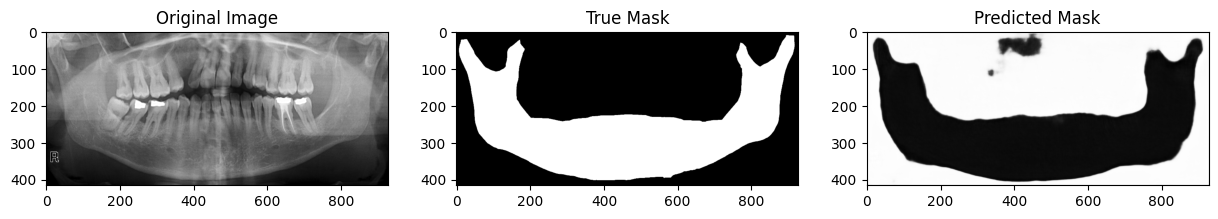

IoU score: 0.3825419843196869


In [ ]:
# Display the original image, true mask, and predicted mask
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(true_mask, cmap='gray')  # Display the true mask
plt.title('True Mask')
plt.subplot(1,3,3)
plt.imshow(predicted_mask, cmap='gray')  # Display the predicted mask
plt.title('Predicted Mask')
plt.show()

# Print the IoU score
print(f"IoU score: {iou_score}")

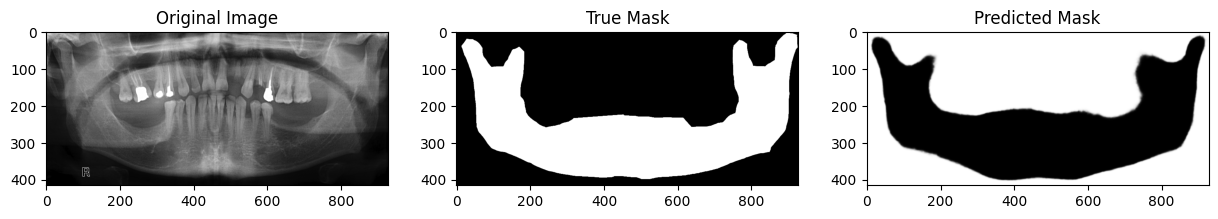

IoU score: 0.15544231235980988


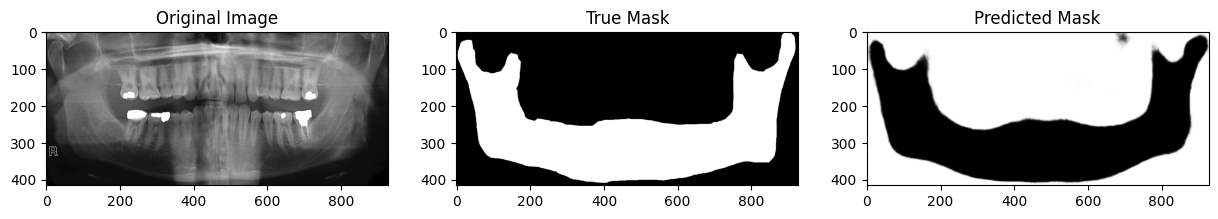

IoU score: 0.14367008209228516


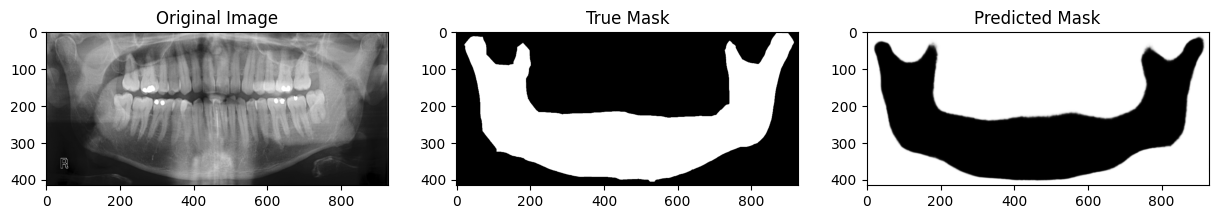

IoU score: 0.14260299503803253


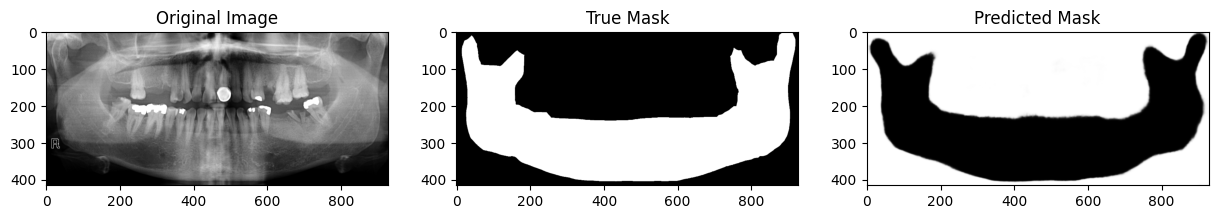

IoU score: 0.1940896362066269


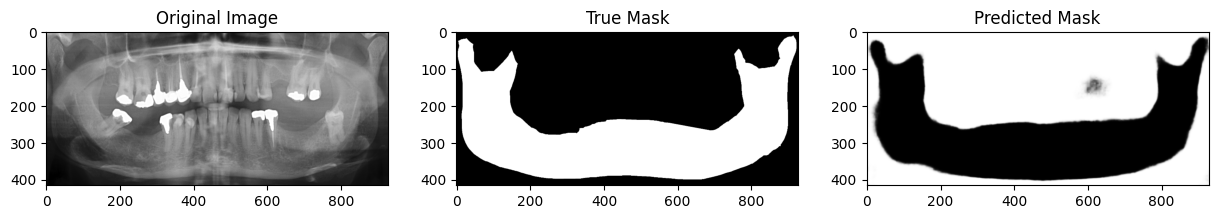

IoU score: 0.1775762289762497


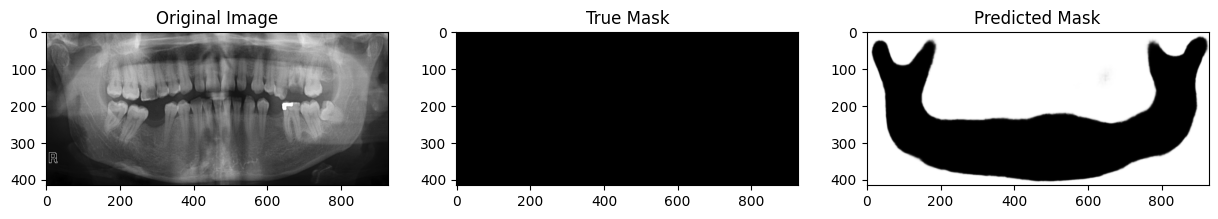

IoU score: 0.7409467101097107


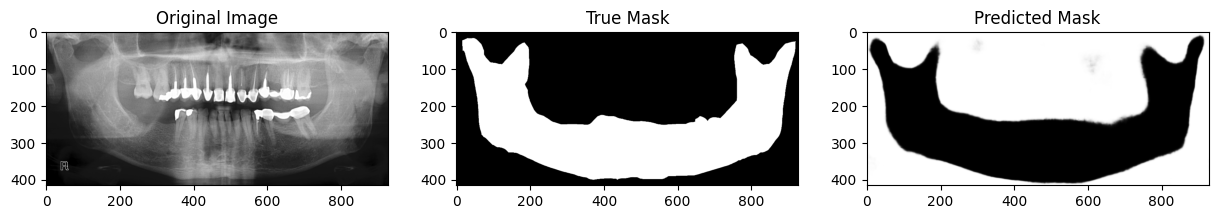

IoU score: 0.16921480000019073


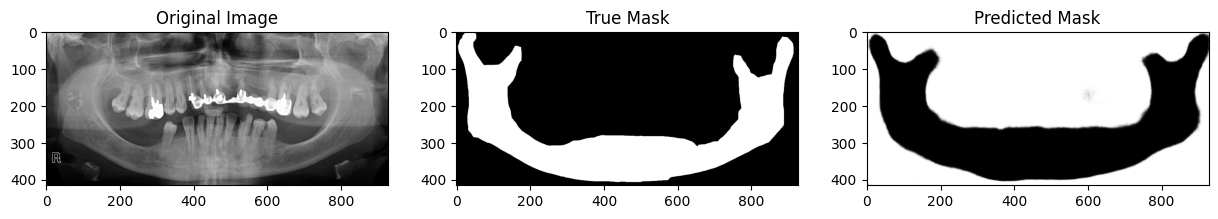

IoU score: 0.10687023401260376


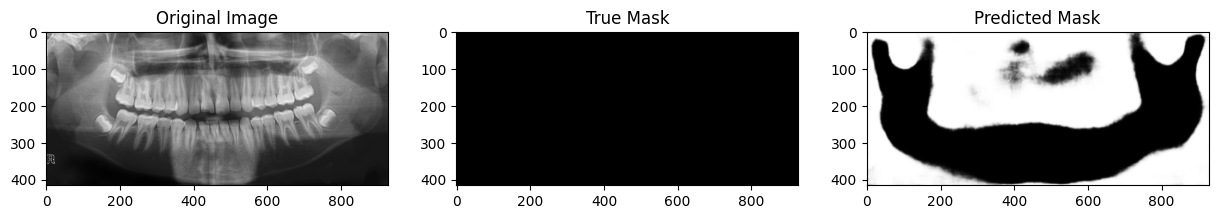

IoU score: 0.8024934530258179


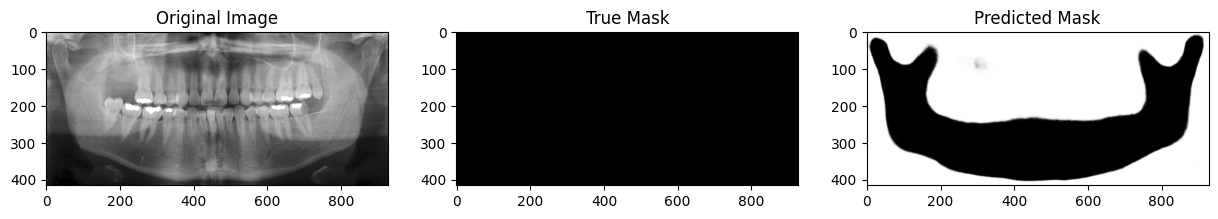

IoU score: 0.7398898601531982


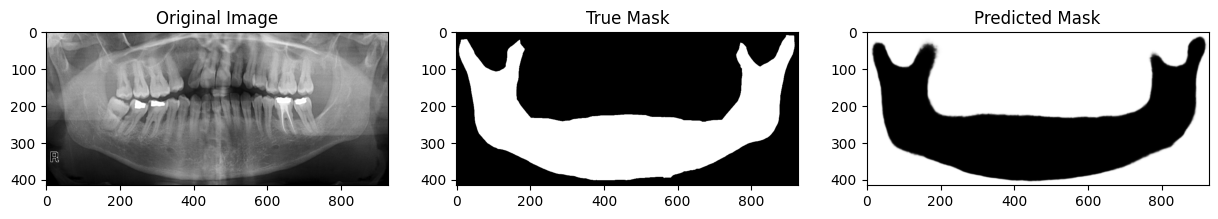

IoU score: 0.10849316418170929


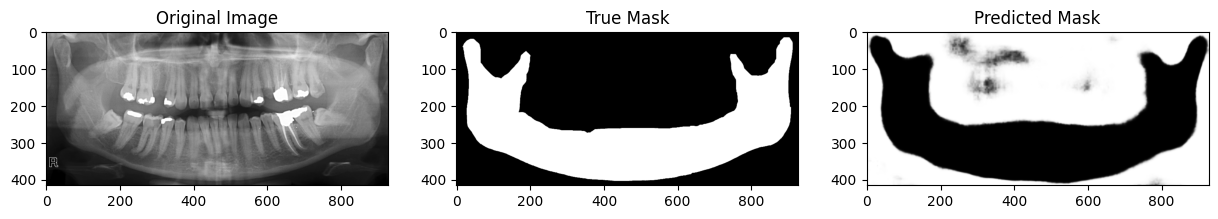

IoU score: 0.14326228201389313


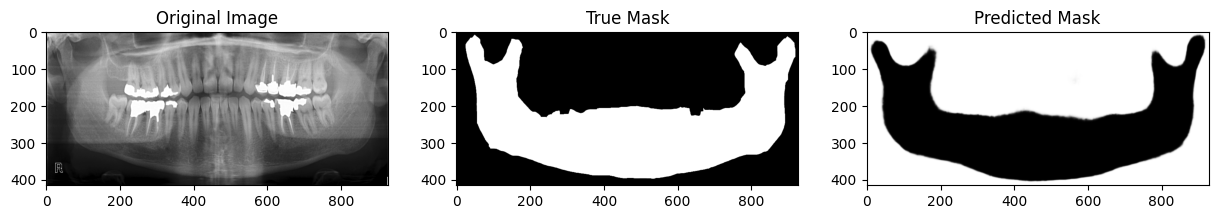

IoU score: 0.155250683426857


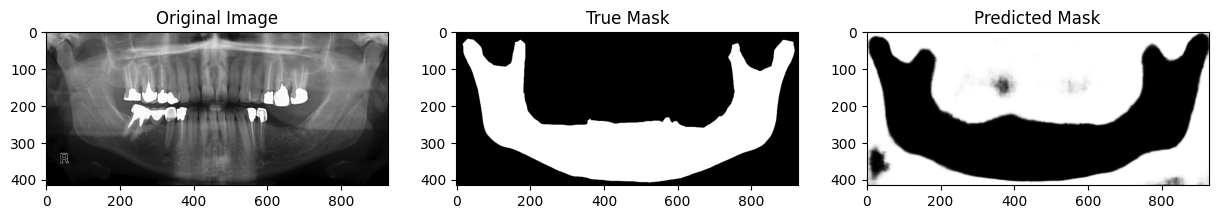

IoU score: 0.1328054517507553


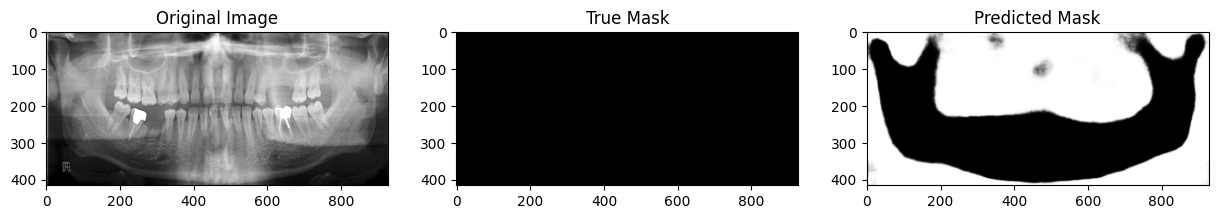

IoU score: 0.7739503979682922


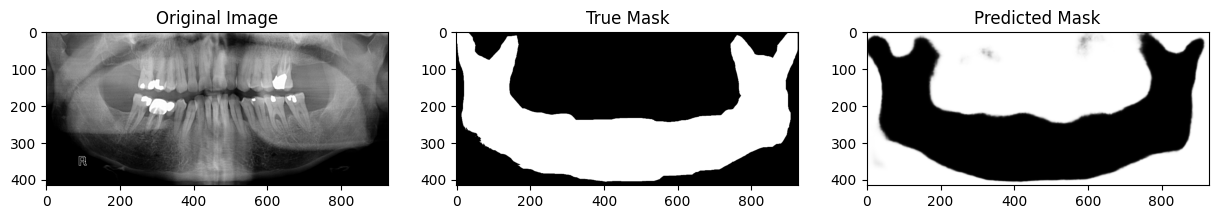

IoU score: 0.22927750647068024


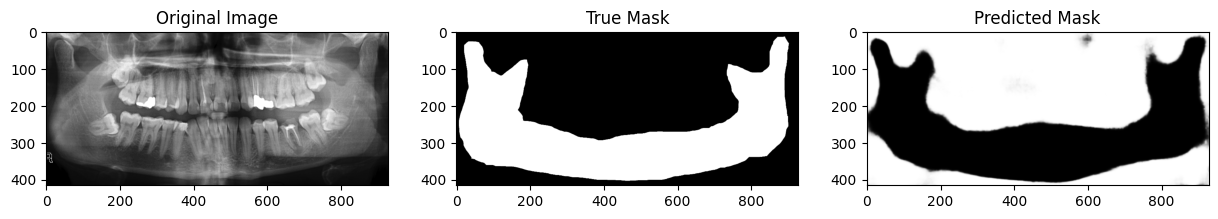

IoU score: 0.1756623387336731


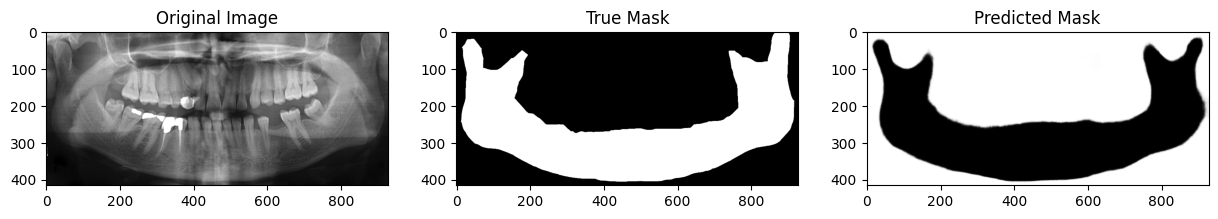

IoU score: 0.1503736525774002


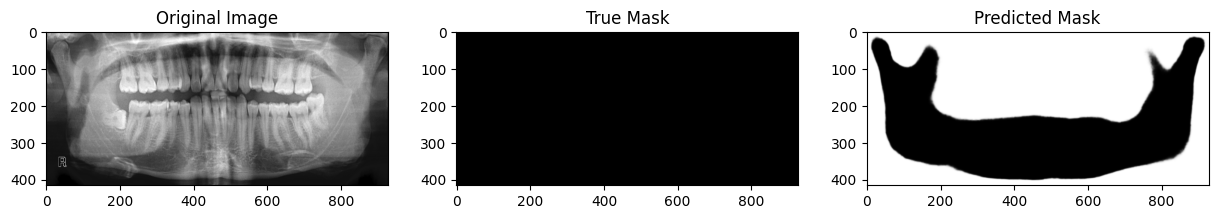

IoU score: 0.7579472064971924


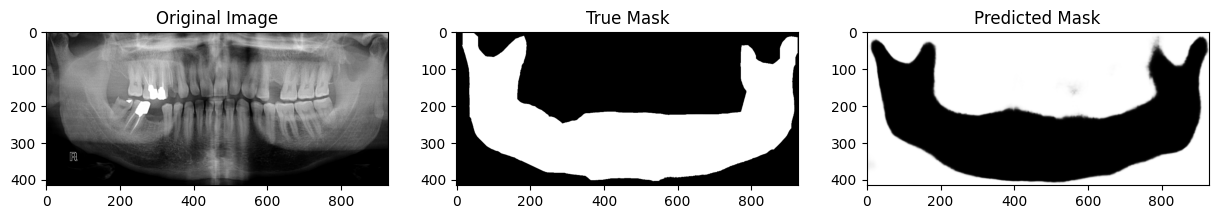

IoU score: 0.2234763205051422


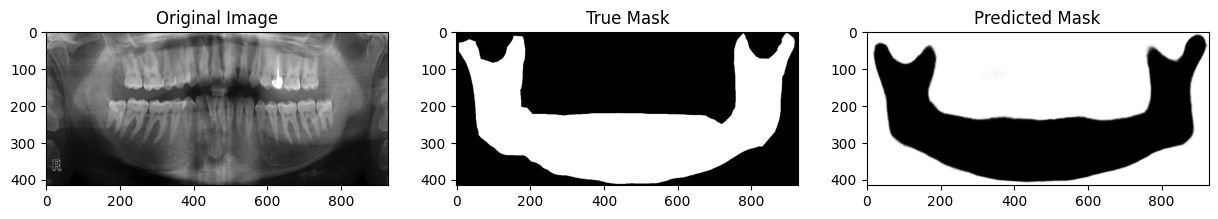

IoU score: 0.1643543541431427


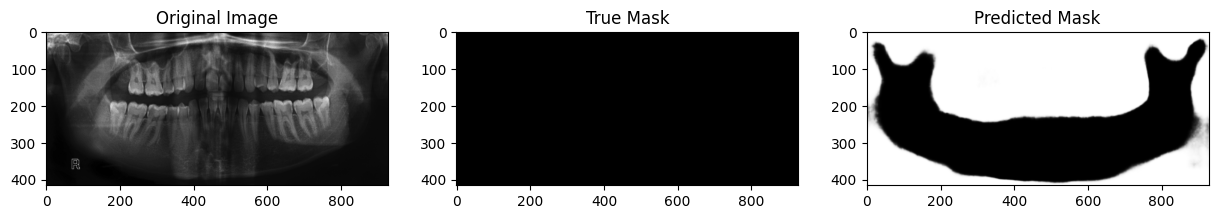

IoU score: 0.785915195941925


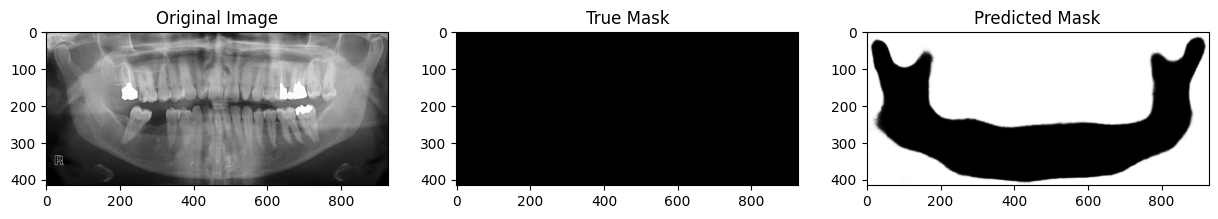

IoU score: 0.7738364338874817


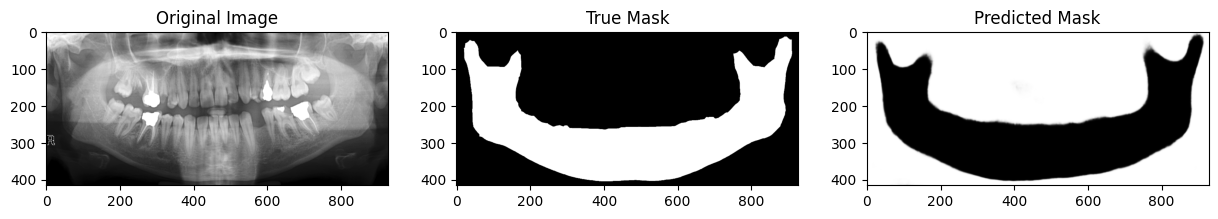

IoU score: 0.1128445416688919


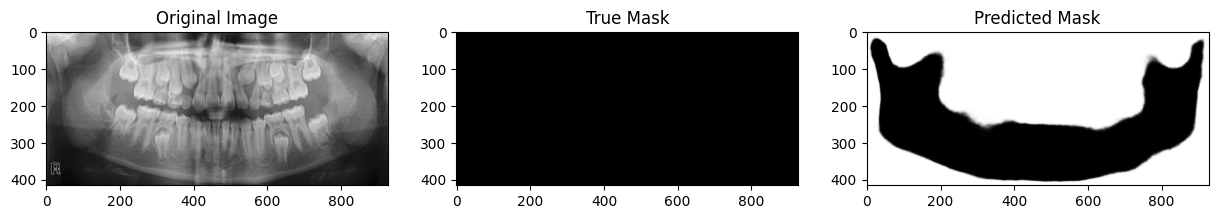

IoU score: 0.7895261645317078


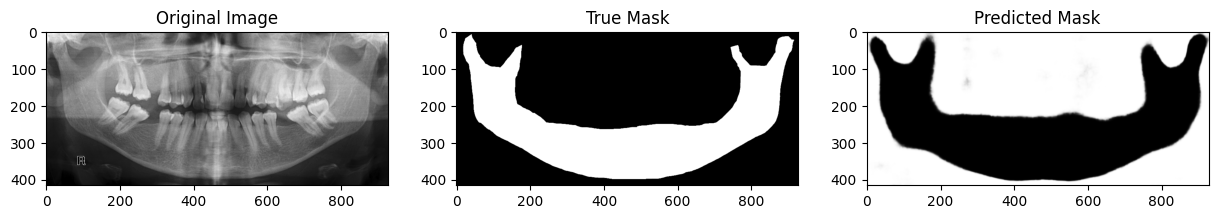

IoU score: 0.08314595371484756


In [ ]:
import os

# Dapatkan semua nama file dalam direktori gambar tes
test_image_dir = '/content/drive/MyDrive/segmentasi/segmentasi/test/mandible/images'
test_mask_dir = '/content/drive/MyDrive/segmentasi/segmentasi/test/mandible/masks'
test_image_files = os.listdir(test_image_dir)

# Loop melalui setiap file
for image_file in test_image_files:
    # Pastikan path ke mask yang sesuai ada
    mask_file = image_file  # Asumsikan nama file mask sama dengan nama file gambar
    if mask_file in os.listdir(test_mask_dir):
        image_path = os.path.join(test_image_dir, image_file)
        mask_path = os.path.join(test_mask_dir, mask_file)

        # Panggil fungsi predict_and_score
        original_img, true_mask, predicted_mask, iou_score = predict_and_score(image_path, mask_path)

        # Tampilkan gambar asli, masker sebenarnya, dan masker yang diprediksi
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(original_img, cmap='gray')
        plt.title('Original Image')
        plt.subplot(1,3,2)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True Mask')
        plt.subplot(1,3,3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.show()

        # Cetak skor IoU
        print(f"IoU score: {iou_score}")
    else:
        print(f"No corresponding mask found for image {image_file}")